In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset
import hashlib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load datasets
train_transaction = pd.read_csv("/content/drive/MyDrive/cc_dataset/train_transaction.csv")
train_identity = pd.read_csv("/content/drive/MyDrive/cc_dataset/train_identity.csv")


# Merge transaction and identity data
train_df = train_transaction.merge(train_identity, on="TransactionID", how="left")


# Assume the dataset is loaded into a DataFrame called df
# For example:
# df = pd.read_csv('train_transaction.csv')

# Define a reference date (the base date for TransactionDT)
# Many use '2017-11-30' as the reference for this dataset
start_date = pd.Timestamp('2017-11-30')

# Convert TransactionDT (seconds elapsed) to a datetime column
train_df['TransactionDT_datetime'] = pd.to_datetime(train_df['TransactionDT'], unit='s', origin=start_date)

# Extract useful time-based features
train_df['trans_hour'] = train_df['TransactionDT_datetime'].dt.hour            # Hour of the day
train_df['trans_day'] = train_df['TransactionDT_datetime'].dt.day               # Day of the month
train_df['trans_weekday'] = train_df['TransactionDT_datetime'].dt.dayofweek      # Day of the week (0=Monday, 6=Sunday)
train_df['trans_month'] = train_df['TransactionDT_datetime'].dt.month           # Month
train_df['trans_dayofyear'] = train_df['TransactionDT_datetime'].dt.dayofyear     # Day of the year

# You might also want the elapsed days from the start date
# train_df['elapsed_days'] = (train_df['TransactionDT_datetime'] - start_date).dt.days

def generate_entity_id(row):
    """
    Generate a unique entity identifier based on the card, address, time, and D1 features.
    The features are concatenated into a single string and then hashed using MD5.
    """
    # Convert each feature to string and concatenate them with a separator
    fingerprint = f"{row['card1']}_{row['card2']}_{row['card3']}_{row['card5']}_{row['addr1']}_{row['addr2']}"
    # Compute the MD5 hash of the fingerprint and return the hexadecimal digest
    return hashlib.md5(fingerprint.encode('utf-8')).hexdigest()

# Assume df is your DataFrame containing the columns: 'card', 'address', 'time', and 'D1'
# train_df['ENTITY_ID'] = train_df.apply(generate_entity_id, axis=1)

# Display a few rows to verify the new features
print(train_df[['TransactionDT', 'TransactionDT_datetime', 'trans_hour', 'trans_weekday','card1','addr1']].head())



   TransactionDT TransactionDT_datetime  trans_hour  trans_weekday  card1  \
0          86400    2017-12-01 00:00:00           0              4  13926   
1          86401    2017-12-01 00:00:01           0              4   2755   
2          86469    2017-12-01 00:01:09           0              4   4663   
3          86499    2017-12-01 00:01:39           0              4  18132   
4          86506    2017-12-01 00:01:46           0              4   4497   

   addr1  
0  315.0  
1  325.0  
2  330.0  
3  476.0  
4  420.0  


In [ ]:
print(train_df[['TransactionDT', 'TransactionDT_datetime', 'trans_hour', 'trans_weekday', 'elapsed_days','ENTITY_ID','card1','card2']].head())

   TransactionDT TransactionDT_datetime  trans_hour  trans_weekday  \
0          86400    2017-12-01 00:00:00           0              4   
1          86401    2017-12-01 00:00:01           0              4   
2          86469    2017-12-01 00:01:09           0              4   
3          86499    2017-12-01 00:01:39           0              4   
4          86506    2017-12-01 00:01:46           0              4   

   elapsed_days                         ENTITY_ID  card1  card2  
0             1  6abdc24e927f42d73e31e8dfab05b0e7  13926    NaN  
1             1  ea9290514570fe7875d8969f35c45fc3   2755  404.0  
2             1  a64a962e3e9dcbf7df3d4b133d37d040   4663  490.0  
3             1  b32384f80f08541077fbb79b526c4998  18132  567.0  
4             1  2628345a7321877be43058b62f2b080d   4497  514.0  


In [ ]:
train_df_2 = train_df.drop(columns=["isFraud"])
# train_df_2 = train_df.drop(columns=["TransactionID", "isFraud"])
c = (train_df_2.dtypes == 'object')
n = (train_df_2.dtypes != 'object')
cat_id_cols = list(c[c].index)
num_id_cols = list(n[n].index)

print(cat_id_cols, "\n")
print("number categorical identity features: ", len(cat_id_cols), "\n\n")
print(num_id_cols, "\n")
print("number numerical identity features: ", len(num_id_cols))





['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'] 

number categorical identity features:  31 


['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53'

In [ ]:
low_missing_cat_cols = []      # lower than 15% missing values
medium_missing_cat_cols = []   # between 15% and 90% missing
many_missing_cat_cols = []     # more than 90% missing

for i in cat_id_cols:
    percentage = train_df_2[i].isnull().sum() * 100 / len(train_df_2[i])
    if percentage < 15:
        low_missing_cat_cols.append(i)
    elif percentage >= 15 and percentage < 60:
        medium_missing_cat_cols.append(i)
    else:
        many_missing_cat_cols.append(i)

print("cat_id_cols: \n\n")
print("number low missing: ", len(low_missing_cat_cols), "\n")
print("number medium missing: ", len(medium_missing_cat_cols), "\n")
print("number many missing: ", len(many_missing_cat_cols), "\n")

cat_id_cols: 


number low missing:  3 

number medium missing:  10 

number many missing:  18 



In [ ]:
low_missing_num_cols = []      # lower than 15% missing values
medium_missing_num_cols = []   # between 15% and 60% missing
many_missing_num_cols = []     # more than 60% missing

for i in num_id_cols:
    percentage = train_df_2[i].isnull().sum() * 100 / len(train_df_2[i])
    if percentage < 15:
        low_missing_num_cols.append(i)
    elif percentage >= 15 and percentage < 60:
        medium_missing_num_cols.append(i)
    else:
        many_missing_num_cols.append(i)

print("num_id_cols: \n\n")
print("number low missing: ", len(low_missing_num_cols), "\n")
print("number medium missing: ", len(medium_missing_num_cols), "\n")
print("number many missing: ", len(many_missing_num_cols), "\n")

num_id_cols: 


number low missing:  162 

number medium missing:  56 

number many missing:  190 



In [ ]:
print("shape before dropping num_trans_cols: ", train_df.shape, "\n")
train_df = train_df.drop(columns = many_missing_num_cols)
train_df_2 = train_df_2.drop(columns = many_missing_num_cols)
print("shape after dropping num_trans_cols: ", train_df.shape, "\n\n")




# because we dropped some numerical columns from the dataframe,
# we must create the list 'num_trans_cols' and
# 'num_id_cols' again such that the dropped cols are no longer in them
n = (train_df_2.dtypes != 'object')
num_trans_cols = list(n[n].index)


shape before dropping num_trans_cols:  (590540, 440) 

shape after dropping num_trans_cols:  (590540, 250) 




In [ ]:
train_df = train_df.drop(columns = ["TransactionDT_datetime"])
train_df_2 = train_df_2.drop(columns = ["TransactionDT_datetime"])
low_missing_num_cols.remove("TransactionDT_datetime")
print(low_missing_num_cols)

['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', '

In [ ]:
#Low missing values



from sklearn.impute import SimpleImputer

print("index before imputation: ", train_df.index, "\n")
print("columns before imputation: ", train_df.columns, "\n")

print("starting imputation..... \n\n")
my_imputer = SimpleImputer(strategy = 'mean')
my_imputer.fit(train_df[low_missing_num_cols])

#print("values before imputing: ", train_transaction[low_missing_num_trans_cols], "\n")

train_df[low_missing_num_cols] = my_imputer.transform(train_df[low_missing_num_cols])

print("index after imputation: ", train_df.index, "\n")
print("columns after imputation: ", train_df.columns, "\n")

print("values after imputing: ", train_df[low_missing_num_cols], "\n")

print("As we can see the imputation was successful! \n")

index before imputation:  RangeIndex(start=0, stop=590540, step=1) 

columns before imputation:  Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'trans_hour',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_dayofyear'],
      dtype='object', length=249) 

starting imputation..... 


index after imputation:  RangeIndex(start=0, stop=590540, step=1) 

columns after imputation:  Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'trans_hour',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_dayofyear'],
      dtype='object', length=249) 

values after imputing:          TransactionID  TransactionDT  TransactionAmt    card1       card2  \
0           2987000

In [ ]:
#Medium missing values
from sklearn.impute import SimpleImputer

print("index before imputation: ", train_df.index, "\n")
print("columns before imputation: ", train_df.columns, "\n")

print("starting imputation..... \n\n")
my_imputer = SimpleImputer(strategy = 'median')
my_imputer.fit(train_df[medium_missing_num_cols])

#print("values before imputing: ", train_transaction[low_missing_num_trans_cols], "\n")

train_df[medium_missing_num_cols] = my_imputer.transform(train_df[medium_missing_num_cols])

print("index after imputation: ", train_df.index, "\n")
print("columns after imputation: ", train_df.columns, "\n")

print("values after imputing: ", train_df[medium_missing_num_cols], "\n")

print("As we can see the imputation was successful! \n")

index before imputation:  RangeIndex(start=0, stop=590540, step=1) 

columns before imputation:  Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'trans_hour',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_dayofyear'],
      dtype='object', length=249) 

starting imputation..... 


index after imputation:  RangeIndex(start=0, stop=590540, step=1) 

columns after imputation:  Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'trans_hour',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_dayofyear'],
      dtype='object', length=249) 

values after imputing:          dist1     D2    D3    D4    D5    D11    D15   V1   V2   V3  ...  V85  \
0        19.0  

In [ ]:
num_trans_cols.remove("TransactionDT_datetime")
print(num_trans_cols)

['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V10

In [ ]:
print(train_df[num_trans_cols].isnull().sum().sum())
print("train_df.memory_usage(): ", train_df.info(), "\n")

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 431 entries, TransactionID to ENTITY_ID
dtypes: float64(398), int64(1), object(32)
memory usage: 1.9+ GB
train_df.memory_usage():  None 



In [ ]:
object_counter = 0
int_counter = 0
float_counter = 0

not_detected = []

for i in train_df.columns:
        if train_df[i].dtype == 'object':
            object_counter += 1
        elif train_df[i].dtype == 'int':
            int_counter += 1
        elif train_df[i].dtype in ['float', 'float16', 'float32', 'float64']:
            float_counter += 1
        else:
            not_detected.append(i)

print("transaction_data has ", "\n")
print(object_counter, "object columns, \n")
print(int_counter, "int columns, \n")
print(float_counter, "float columns \n")



transaction_data has  

31 object columns, 

1 int columns, 

217 float columns 



In [ ]:
print("shape before dropping many_missing_cat_trans_cols: ", train_df.shape, "\n")
train_df = train_df.drop(columns = many_missing_cat_cols)
train_df_2 = train_df_2.drop(columns = many_missing_cat_cols)
print("shape after dropping many_missing_cat_trans_cols: ", train_df.shape, "\n\n")


# because we dropped some categorical columns from the dataframe,
# we must create the list 'cat_trans_cols' and
# 'cat_id_cols' again such that the dropped cols are no longer in them
c = (train_df.dtypes == 'object')
cat_trans_cols = list(c[c].index)



shape before dropping many_missing_cat_trans_cols:  (590540, 249) 

shape after dropping many_missing_cat_trans_cols:  (590540, 231) 




In [ ]:
for col in cat_trans_cols:
    print(col, train_df[col].nunique(), "\n")



ProductCD 5 

card4 4 

card6 4 

P_emaildomain 59 

M1 2 

M2 2 

M3 2 

M4 3 

M5 2 

M6 2 

M7 2 

M8 2 

M9 2 



In [ ]:
low_card_trans_cols_1 = []
high_card_trans_cols_1 = []

for i in cat_trans_cols:
    if train_df[i].nunique() < 6:
        low_card_trans_cols_1.append(i)
    else:
        high_card_trans_cols_1.append(i)

print(low_card_trans_cols_1)
print(high_card_trans_cols_1)

['ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
['P_emaildomain']


In [ ]:
for i in cat_trans_cols:
    most_frequent_value = train_df[i].mode()[0]
    print("For column: ", i, "the most frequent value is: ", most_frequent_value, "\n")
    train_df[i].fillna(most_frequent_value, inplace = True)

For column:  ProductCD the most frequent value is:  W 

For column:  card4 the most frequent value is:  visa 

For column:  card6 the most frequent value is:  debit 

For column:  P_emaildomain the most frequent value is:  gmail.com 

For column:  M1 the most frequent value is:  T 



<ipython-input-16-ae4b4beae7cf>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[i].fillna(most_frequent_value, inplace = True)


For column:  M2 the most frequent value is:  T 

For column:  M3 the most frequent value is:  T 

For column:  M4 the most frequent value is:  M0 

For column:  M5 the most frequent value is:  F 

For column:  M6 the most frequent value is:  F 

For column:  M7 the most frequent value is:  F 

For column:  M8 the most frequent value is:  F 

For column:  M9 the most frequent value is:  T 



In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
print("transaction_data.shape before label-encoding: ", train_df.shape, "\n")
for col in high_card_trans_cols_1:
  train_df[col] = label_encoder.fit_transform(train_df[col])

print("transaction_data.shape after label-encoding: ", train_df.shape, "\n")
print("transaction_data[high_card_trans_cols] after label_encoding: ",train_df[high_card_trans_cols_1], "\n")

transaction_data.shape before label-encoding:  (590540, 231) 

transaction_data.shape after label-encoding:  (590540, 231) 

transaction_data[high_card_trans_cols] after label_encoding:          P_emaildomain
0                  16
1                  16
2                  35
3                  53
4                  16
...               ...
590535             16
590536             16
590537             16
590538              2
590539             16

[590540 rows x 1 columns] 



In [ ]:
print("shape before encoding: ", train_df.shape, "\n")
print("columns to encode: ", low_card_trans_cols_1, "\n")
print("transaction_data.columns.to_list() before encoding: ", train_df.columns.to_list(), "\n")

# this line does the onehot encoding
low_card_trans_encoded = pd.get_dummies(train_df[low_card_trans_cols_1], dummy_na = False)

low_card_trans_encoded = low_card_trans_encoded.astype(int)
print("shape after encoding: ", train_df.shape, "\n\n")
print("shape of new dataframe: ", low_card_trans_encoded.shape, "\n\n")
print("newly generated columns: ", low_card_trans_encoded.columns, "\n")
print("low_card_trans_encoded.info(): ", low_card_trans_encoded.info(),"\n")
print("transaction_data.columns.to_list() after encoding: ", train_df.columns.to_list(), "\n")
print("low_card_trans_encoded: ", low_card_trans_encoded.head(), "\n")

shape before encoding:  (590540, 231) 

columns to encode:  ['ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'] 

transaction_data.columns.to_list() before encoding:  ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63'

In [ ]:
print("transaction_data.shape before concatting: ", train_df.shape, "\n")
print("low_card_trans_encoded.shape before concatting: ", low_card_trans_encoded.shape, "\n")

train_concatted = pd.concat([train_df, low_card_trans_encoded], axis = 1)
train_concatted.drop(columns = low_card_trans_cols_1, inplace = True)

print("train_concatted.shape after concatting: ", train_concatted.shape, "\n")
print("train_concatted.columns after concatting: ", train_concatted.columns, "\n")

#del low_card_trans_encoded
#del transaction_data

print(train_concatted.info())
train_concatted.head()







transaction_data.shape before concatting:  (590540, 231) 

low_card_trans_encoded.shape before concatting:  (590540, 32) 

train_concatted.shape after concatting:  (590540, 251) 

train_concatted.columns after concatting:  Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F', 'M7_T', 'M8_F', 'M8_T', 'M9_F',
       'M9_T'],
      dtype='object', length=251) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 251 entries, TransactionID to M9_T
dtypes: float64(217), int64(34)
memory usage: 1.1 GB
None


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,2987000.0,0,86400.0,68.5,13926.0,362.555488,150.0,142.0,315.0,87.0,...,1,0,0,1,1,0,1,0,0,1
1,2987001.0,0,86401.0,29.0,2755.0,404.000000,150.0,102.0,325.0,87.0,...,0,1,0,1,1,0,1,0,0,1
2,2987002.0,0,86469.0,59.0,4663.0,490.000000,150.0,166.0,330.0,87.0,...,1,0,1,0,1,0,1,0,1,0
3,2987003.0,0,86499.0,50.0,18132.0,567.000000,150.0,117.0,476.0,87.0,...,0,1,1,0,1,0,1,0,0,1
4,2987004.0,0,86506.0,50.0,4497.0,514.000000,150.0,102.0,420.0,87.0,...,1,0,1,0,1,0,1,0,0,1


In [ ]:
train_concatted.to_csv("/content/drive/MyDrive/ieeecis/train_concatted_v2.csv")
# Save the list to a CSV file
pd.DataFrame(num_trans_cols).to_csv("/content/drive/MyDrive/ieeecis/num_trans_cols_v2.csv", index=False, header=False)

# # ... (Later, to load the list)

# # Load the list from the CSV file
# num_trans_cols = pd.read_csv("/content/drive/MyDrive/ieeecis/num_trans_cols.csv", header=None).iloc[:, 0].tolist()

In [ ]:
train_concatted = pd.read_csv("/content/drive/MyDrive/ieeecis/train_concatted.csv")
num_trans_cols = pd.read_csv("/content/drive/MyDrive/ieeecis/num_trans_cols.csv", header=None).iloc[:, 0].tolist()

In [ ]:
# Separate normal & fraudulent samples
X_normal = train_concatted[train_concatted['isFraud'] == 0]  # Normal transactions
X_anomaly = train_concatted[train_concatted['isFraud'] == 1]  # Fraudulent transactions (for evaluation)

print(f"Train shape: {X_normal.shape}, Test shape: {X_anomaly.shape}")

# Drop TransactionID and target variable from train dataset for preprocessing
# train_target = train_transaction["isFraud"]
X_normal.drop(columns=["TransactionID", "isFraud"], inplace=True)
X_anomaly.drop(columns=["TransactionID","isFraud"], inplace=True)
# X_normal.drop(columns=["isFraud"], inplace=True)
# X_anomaly.drop(columns=["isFraud"], inplace=True)

num_trans_cols.remove("TransactionID")

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
X_normal[num_trans_cols] = scaler.fit_transform(X_normal[num_trans_cols])
X_anomaly[num_trans_cols] = scaler.transform(X_anomaly[num_trans_cols])


# Convert data types to reduce memory usage
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
    return df

#train_df = reduce_memory(train_df)
#test_df = reduce_memory(test_df)
# Final processed datasets
print(f"Train shape: {X_normal.shape}, Test shape: {X_anomaly.shape}")

Train shape: (569877, 464), Test shape: (20663, 464)


<ipython-input-4-1c8cff8eda03>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normal.drop(columns=["TransactionID", "isFraud"], inplace=True)
<ipython-input-4-1c8cff8eda03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_anomaly.drop(columns=["TransactionID","isFraud"], inplace=True)
<ipython-input-4-1c8cff8eda03>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normal

Train shape: (569877, 462), Test shape: (20663, 462)


<ipython-input-4-1c8cff8eda03>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_anomaly[num_trans_cols] = scaler.transform(X_anomaly[num_trans_cols])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.utils.parametrizations as param
import torch.nn.functional as F



# PyTorch Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)

        # Xavier initialization (equivalent to TensorFlow's `init_kernel`)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        output = self.fc3(z)  # Last layer (no activation)
        return output

# PyTorch Encoder Model
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, latent_dim)

        # Xavier initialization (equivalent to TensorFlow's `init_kernel`)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x),negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.2)
        x = self.fc3(x)  # Last layer (latent space) has no activation
        return x

# Define Discriminator Dxz
class DiscriminatorXZ(nn.Module):
    def __init__(self, x_dim, z_dim, do_spectral_norm=False):
        """
        Args:
            x_dim (int): Dimensionality of the x input.
            z_dim (int): Dimensionality of the z input.
            do_spectral_norm (bool): If True, apply spectral normalization to linear layers.
        """
        super(DiscriminatorXZ, self).__init__()

        # Helper: apply spectral normalization if desired
        sn = torch.nn.utils.spectral_norm if do_spectral_norm else lambda layer: layer

        # D(x) branch: dense layer -> batch norm -> leaky ReLU
        self.x_fc1 = sn(nn.Linear(x_dim, 128))
        self.x_bn1 = nn.BatchNorm1d(128)

        # D(z) branch: dense layer -> leaky ReLU -> dropout
        self.z_fc1 = sn(nn.Linear(z_dim, 128))
        self.dropout = nn.Dropout(0.5)  # dropout rate 0.5

        # Combined branch (D(x,z)): after concatenation of x and z branches
        self.y_fc1 = sn(nn.Linear(128 + 128, 256))  # concatenated size = 256
        self.y_fc2 = sn(nn.Linear(256, 1))  # output logits

        # Xavier (Glorot) initialization for all linear layers
        nn.init.xavier_uniform_(self.x_fc1.weight)
        nn.init.xavier_uniform_(self.z_fc1.weight)
        nn.init.xavier_uniform_(self.y_fc1.weight)
        nn.init.xavier_uniform_(self.y_fc2.weight)

    def forward(self, x, z):
        # D(x) branch:
        x_out = self.x_fc1(x)
        x_out = self.x_bn1(x_out)
        x_out = F.leaky_relu(x_out,negative_slope=0.2)

        # D(z) branch:
        z_out = self.z_fc1(z)
        z_out = F.leaky_relu(z_out,negative_slope=0.2)
        z_out = self.dropout(z_out)  # dropout is active only in training mode

        # Concatenate the branches along the feature dimension
        y = torch.cat([x_out, z_out], dim=1)

        # Combined branch:
        y = self.y_fc1(y)
        y = F.leaky_relu(y,negative_slope=0.2)
        y = self.dropout(y)

        intermediate_layer = y  # For feature matching

        # Final logits layer (no activation)
        logits = self.y_fc2(y)

        return logits, intermediate_layer


# Define Discriminator Dxx
class DiscriminatorXX(nn.Module):
    def __init__(self, input_dim, do_spectral_norm=True):
        super(DiscriminatorXX, self).__init__()

        # Apply spectral normalization if enabled
        spectral_layer = torch.nn.utils.spectral_norm if do_spectral_norm else lambda x: x

        # Fully connected layers with Spectral Normalization
        self.fc1 = spectral_layer(nn.Linear(input_dim * 2, 256))
        self.fc2 = spectral_layer(nn.Linear(256, 128))
        self.fc3 = spectral_layer(nn.Linear(128, 1))  # Final output layer

        self.dropout = nn.Dropout(0.5)  # Dropout layer

        # Xavier Initialization (equivalent to TensorFlow's `init_kernel`)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x, rec_x):
        # Concatenate x and rec_x
        net = torch.cat([x, rec_x], dim=1)

        # Layer 1
        net = F.leaky_relu(self.fc1(net),negative_slope=0.2)
        net = self.dropout(net) if self.training else net  # Dropout only during training

        # Layer 2
        net = F.leaky_relu(self.fc2(net),negative_slope=0.2)
        net = self.dropout(net) if self.training else net  # Dropout only during training

        intermediate_layer = net  # Save intermediate layer for feature matching

        # Layer 3 (Logits)
        logits = self.fc3(net)  # No activation in final layer

        return logits, intermediate_layer

# Define Discriminator Dzz
class DiscriminatorZZ(nn.Module):
    def __init__(self, latent_dim, do_spectral_norm=False):
        super(DiscriminatorZZ, self).__init__()

        # If spectral normalization is desired, wrap the linear layers with it.
        sn = torch.nn.utils.spectral_norm if do_spectral_norm else lambda x: x

        # First layer: input dimension is latent_dim * 2 due to concatenation of z and rec_z.
        self.fc1 = sn(nn.Linear(latent_dim * 2, 64))
        # Second layer.
        self.fc2 = sn(nn.Linear(64, 32))
        # Third (output) layer: produces logits.
        self.fc3 = sn(nn.Linear(32, 1))
        # Dropout layer with rate 0.2.
        self.dropout = nn.Dropout(0.5)

        # Xavier initialization (Glorot Uniform)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, z, rec_z):
        # Concatenate along the feature dimension.
        net = torch.cat([z, rec_z], dim=1)

        # Layer 1: Dense -> Leaky ReLU -> Dropout.
        net = F.leaky_relu(self.fc1(net),negative_slope=0.2)
        net = self.dropout(net)  # Dropout is active only in training mode.

        # Layer 2: Dense -> Leaky ReLU -> Dropout.
        net = F.leaky_relu(self.fc2(net),negative_slope=0.2)
        net = self.dropout(net)

        # Save intermediate layer for feature matching.
        intermediate_layer = net

        # Layer 3: Dense to produce logits (no activation).
        logits = self.fc3(net)
        return logits, intermediate_layer



In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm

class DiscriminatorXZ_1(nn.Module):
    def __init__(self, input_dim, latent_dim):
        """
        Improved Dₓz discriminator that takes the concatenated input and latent vector,
        and returns both the final logits and an intermediate feature representation.

        Args:
            input_dim (int): Dimensionality of input x.
            latent_dim (int): Dimensionality of latent vector z.
        """
        super(DiscriminatorXZ_1, self).__init__()

        # The network takes a concatenated vector of dimension (input_dim + latent_dim)
        self.fc1 = spectral_norm(nn.Linear(input_dim + latent_dim, 512))
        self.fc2 = spectral_norm(nn.Linear(512, 256))
        self.fc3 = spectral_norm(nn.Linear(256, 128))  # Intermediate feature layer
        self.fc4 = spectral_norm(nn.Linear(128, 1))    # Final logits layer

        # Activation function: LeakyReLU with a small negative slope
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, z):
        # Concatenate the input and latent vector along the feature dimension
        xz = torch.cat([x, z], dim=1)

        out = self.fc1(xz)
        out = self.leaky_relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)

        # Use the output of the third layer as intermediate features
        intermediate = self.fc3(out)
        intermediate = self.leaky_relu(intermediate)

        logits = self.fc4(intermediate)
        # If you plan to use BCEWithLogitsLoss, don't apply Sigmoid here.
        return logits, intermediate


class DiscriminatorXX_1(nn.Module):
    def __init__(self, input_dim):
        """
        Discriminator for comparing two x inputs.

        Args:
            input_dim (int): Dimensionality of the input x.
        """
        super(DiscriminatorXX_1, self).__init__()
        # Input is a concatenation of two x vectors: dimension = 2 * input_dim
        self.fc1 = spectral_norm(nn.Linear(2 * input_dim, 512))
        self.fc2 = spectral_norm(nn.Linear(512, 256))
        self.fc3 = spectral_norm(nn.Linear(256, 128))  # Intermediate features
        self.fc4 = spectral_norm(nn.Linear(128, 1))    # Logits output

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x1, x2):
        # Concatenate the two x vectors along the feature dimension
        x = torch.cat([x1, x2], dim=1)
        out = self.leaky_relu(self.fc1(x))
        out = self.dropout(out)
        out = self.leaky_relu(self.fc2(out))
        out = self.dropout(out)
        intermediate = self.leaky_relu(self.fc3(out))
        logits = self.fc4(intermediate)
        return logits, intermediate


class DiscriminatorZZ_1(nn.Module):
    def __init__(self, latent_dim):
        """
        Discriminator for comparing two latent vectors.

        Args:
            latent_dim (int): Dimensionality of the latent vector z.
        """
        super(DiscriminatorZZ_1, self).__init__()
        # Input is a concatenation of two z vectors: dimension = 2 * latent_dim
        self.fc1 = spectral_norm(nn.Linear(2 * latent_dim, 64))
        # self.fc2 = spectral_norm(nn.Linear(256, 128))
        self.fc3 = spectral_norm(nn.Linear(64, 32))   # Intermediate features
        self.fc4 = spectral_norm(nn.Linear(32, 1))     # Logits output

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.7)

    def forward(self, z1, z2):
        # Concatenate the two latent vectors
        z = torch.cat([z1, z2], dim=1)
        out = self.leaky_relu(self.fc1(z))
        out = self.dropout(out)
        # out = self.leaky_relu(self.fc2(out))
        # out = self.dropout(out)
        intermediate = self.leaky_relu(self.fc3(out))
        logits = self.fc4(intermediate)
        return logits, intermediate

class Encoder_1(nn.Module):
    def __init__(self, input_dim, latent_dim):
        """
        Encoder that maps input x to latent vector z.

        Args:
            input_dim (int): Dimensionality of input x.
            latent_dim (int): Dimensionality of latent space z.
        """
        super(Encoder_1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, latent_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        z = self.fc2(out)
        return z

class Generator_1(nn.Module):
    def __init__(self, latent_dim, output_dim):
        """
        Generator that maps latent vector z to reconstructed input x_rec.

        Args:
            latent_dim (int): Dimensionality of latent space z.
            output_dim (int): Dimensionality of output x (should match input_dim).
        """
        super(Generator_1, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, z):
        out = self.relu(self.fc1(z))
        x_rec = self.fc2(out)
        return x_rec


In [ ]:
from sklearn.model_selection import train_test_split
batch_size = 4096
X_train, X_test_normal = train_test_split(X_normal, test_size=0.01, random_state=42)
X_normal_tensor = torch.tensor(X_normal.values.astype(np.float32), dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(X_normal_tensor, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn.functional as F
# Training Loop
import torch
import torch.nn as nn
import torch.optim as optim


# Hyperparameters
input_dim = X_normal.shape[1]
learning_rate_gen = 1e-4   # Generator (Encoder)
learning_rate_disc_xx = 1e-5  # Discriminator (lower than encoder)
learning_rate_enc = 1e-4
learning_rate_disc_xz = 1e-7
learning_rate_disc_zz = 1e-10
latent_dim = 128
x_dim = input_dim
num_epochs = 100
log_interval = 100

# Loss function
criterion = F.binary_cross_entropy_with_logits
criterion_d = nn.BCEWithLogitsLoss(reduction='mean')

# Move models to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks (example constructors; adapt as needed)
encoder = Encoder(x_dim, latent_dim).to(device)
generator = Generator(latent_dim, x_dim).to(device)
discriminator_xz = DiscriminatorXZ(x_dim, latent_dim).to(device)
discriminator_xx = DiscriminatorXX(x_dim).to(device)
discriminator_zz = DiscriminatorZZ(latent_dim).to(device)


# Optimizers
optimizer_D_xz = optim.Adam(discriminator_xz.parameters(), lr=learning_rate_disc_xz, betas=(0.5, 0.999))
optimizer_D_xx = optim.Adam(discriminator_xx.parameters(), lr=learning_rate_disc_xx, betas=(0.5, 0.999))
optimizer_D_zz = optim.Adam(discriminator_zz.parameters(), lr=learning_rate_disc_zz, betas=(0.5, 0.999))

# Separate optimizers for generator and encoder
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_gen, betas=(0.5, 0.999))
optimizer_E = optim.Adam(encoder.parameters(), lr=learning_rate_enc, betas=(0.5, 0.999))

# Define a clipping value (adjust as needed)
discriminator_update_interval=10
# recon_criterion = torch.nn.L1Loss()

torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs):
    encoder.train()
    generator.train()
    discriminator_xz.train()
    discriminator_xx.train()
    discriminator_zz.train()

    # For logging losses per epoch (average per sample)
    total_loss_D_xz = 0.0
    total_loss_D_xx = 0.0
    total_loss_D_zz = 0.0
    total_loss_G = 0.0
    total_loss_E = 0.0
    n_batches = 0

    for i, real_x in enumerate(train_loader):
        # real_x = real_x.to(device)
        real_x = real_x.type(torch.FloatTensor).to(device)
        # real_x.requires_grad = True
        batch_size = real_x.size(0)
        current_batch_size = batch_size
        n_batches += 1

        # Define labels (adapted: real=0, fake=1)
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        if i % discriminator_update_interval == 0:
            # ============================
            # 1. Update Discriminator_xz
            # ============================
            optimizer_D_xz.zero_grad()

            # Real pairs: (x, encoder(x))
            z_enc = encoder(real_x)
            logits_real_xz, _ = discriminator_xz(real_x, z_enc)
            loss_real_xz = criterion_d(logits_real_xz, real_labels)

            # Fake pairs: (generator(z_noise), z_noise)
            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake = generator(z_noise).detach()
            logits_fake_xz, _ = discriminator_xz(x_fake, z_noise)
            loss_fake_xz = criterion_d(logits_fake_xz, fake_labels)

            loss_D_xz = (loss_real_xz + loss_fake_xz) #(loss_real_xz + loss_fake_xz) / 2
            loss_D_xz.backward()
            optimizer_D_xz.step()

            # ============================
            # 2. Update Discriminator_xx
            # ============================
            optimizer_D_xx.zero_grad()

            # Real pairs: (x, x)
            logits_real_xx, _ = discriminator_xx(real_x, real_x)
            loss_real_xx = criterion_d(logits_real_xx, real_labels)

            # Fake pairs: (x, generator(encoder(x)))
            x_rec = generator(encoder(real_x)).detach()
            logits_fake_xx, _ = discriminator_xx(real_x, x_rec)
            loss_fake_xx = criterion_d(logits_fake_xx, fake_labels)

            loss_D_xx = (loss_real_xx + loss_fake_xx)  #(loss_real_xx + loss_fake_xx) / 2
            loss_D_xx.backward()
            optimizer_D_xx.step()

            # ============================
            # 3. Update Discriminator_zz
            # ============================
            optimizer_D_zz.zero_grad()

            # Real pairs: (z, z) where z is sampled from the prior (noise)
            z_prior = torch.randn(batch_size, latent_dim, device=device)
            logits_real_zz, _ = discriminator_zz(z_prior, z_prior)
            loss_real_zz = criterion_d(logits_real_zz, real_labels)

            # Fake pairs: (z, encoder(generator(z)))
            x_fake = generator(z_prior)
            z_rec = encoder(x_fake).detach()
            logits_fake_zz, _ = discriminator_zz(z_prior, z_rec)
            loss_fake_zz = criterion_d(logits_fake_zz, fake_labels)

            loss_D_zz = (loss_real_zz + loss_fake_zz)#(loss_real_zz + loss_fake_zz) / 2
            loss_D_zz.backward()
            optimizer_D_zz.step()

        #### GEN Code
        # Assume the following tensors are already computed:
        # l_generator: logits from some branch of the generator (used for adversarial loss)
        # l_encoder: logits from some branch of the encoder
        # x_logit_real, x_logit_fake: discriminator outputs (logits) for the x branch (real x and reconstructed x)
        # z_logit_real, z_logit_fake: discriminator outputs (logits) for the z branch (real z and reconstructed z)
        # allow_zz: Boolean flag indicating whether to include the z branch in cycle consistency loss
        optimizer_G.zero_grad()
        optimizer_E.zero_grad()

        # z_noise = torch.randn(batch_size, latent_dim, device=device)
        # x_fake = generator(z_noise)
        # l_generator, _ = discriminator_xz(x_fake, z_noise)
        # Adversarial loss for the generator: now we use real label = 0 (instead of 1)
        gen_loss_xz = criterion_d(logits_fake_xz, torch.ones_like(logits_fake_xz))

        # For the encoder, we use the loss computed from discriminator_xz.
        # l_encoder, _ = discriminator_xz(real_x, encoder(real_x))
        # Adversarial loss for the generator: now we use real label = 0 (instead of 1)
        enc_loss_xz = criterion_d(logits_real_xz, torch.zeros_like(logits_real_xz))

        # Cycle consistency loss for the x branch:
        # For real x (should be classified as real, i.e., 0)

        # x_real_dis, _ = discriminator_xx(real_x, real_x)

        # # Fake pairs: (x, generator(encoder(x)))
        # x_rec = generator(encoder(real_x))
        # x_fake_dis, _ = discriminator_xx(real_x, x_rec)


        x_real_gen = criterion_d(logits_real_xx, torch.zeros_like(logits_real_xx))

        # For fake (reconstructed) x (should be classified as fake, i.e., 1)
        x_fake_gen = criterion_d(logits_fake_xx, torch.ones_like(x_fake_dis))

        cost_x = x_real_gen + x_fake_gen

        # # Cycle consistency loss for the z branch:

        # # Real pairs: (z, z) where z is sampled from the prior (noise)
        # z_prior = torch.randn(batch_size, latent_dim, device=device)
        # z_real_dis, _ = discriminator_zz(z_prior, z_prior)

        # # Fake pairs: (z, encoder(generator(z)))
        # x_fake = generator(z_prior)
        # z_rec = encoder(x_fake)
        # z_fake_dis, _ = discriminator_zz(z_prior, z_rec)


        z_real_gen = criterion_d(logits_real_zz, torch.zeros_like(logits_real_zz))
        z_fake_gen = criterion_d(logits_fake_zz, torch.ones_like(logits_fake_zz))
        cost_z = z_real_gen + z_fake_gen
        # --- Cycle consistency loss (Reconstruction Loss) ---
        # Compute reconstruction x_rec = G(E(x)) and compare to real x.
        # x_rec = generator(encoder(real_x))
        # recon_loss = recon_criterion(x_rec, real_x)
        # cycle_consistency_loss = recon_loss

        # Total cycle-consistency loss: include z branch if allowed
        cycle_consistency_loss = cost_x + cost_z
        # cycle_consistency_loss = cost_x

        # Final losses:
        loss_generator = gen_loss_xz + cycle_consistency_loss
        # loss_generator.backward(retain_graph=True)
        # optimizer_G.step()

        loss_encoder = enc_loss_xz + cycle_consistency_loss
        # loss_encoder.backward()
        # optimizer_E.step()

        lambda_cycle = 1.0  # You can increase this value to enforce stronger cycle consistency.

        # Final losses for the generator and encoder:
        loss_generator = gen_loss_xz + lambda_cycle * cycle_consistency_loss

        loss_encoder = enc_loss_xz + lambda_cycle * cycle_consistency_loss

        total_loss = loss_generator + loss_encoder
        total_loss.backward()
        optimizer_G.step()
        optimizer_E.step()


        # Log per-iteration (average loss per sample)
        total_loss_D_xz += loss_D_xz.item() / current_batch_size if i % discriminator_update_interval == 0 else 0
        total_loss_D_xx += loss_D_xx.item() / current_batch_size if i % discriminator_update_interval == 0 else 0
        total_loss_D_zz += loss_D_zz.item() / current_batch_size if i % discriminator_update_interval == 0 else 0
        total_loss_G    += loss_generator.item() / current_batch_size
        total_loss_E    += loss_encoder.item() / current_batch_size


    # End of epoch: compute and log average losses for discriminators (if updated)
    num_disc_updates = (n_batches // discriminator_update_interval) or 1
    avg_loss_D_xz = total_loss_D_xz / num_disc_updates
    avg_loss_D_xx = total_loss_D_xx / num_disc_updates
    avg_loss_D_zz = total_loss_D_zz / num_disc_updates
    avg_loss_G = total_loss_G / n_batches
    avg_loss_E = total_loss_E / n_batches

    print(f"Epoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Average Loss_D_xz: {avg_loss_D_xz:.4f}  Average Loss_D_xx: {avg_loss_D_xx:.4f} Average Loss_D_zz: {avg_loss_D_zz:.4f}")
    # print(f"  Average Loss_D_xz: {avg_loss_D_xz:.4f}  Average Loss_D_xx: {avg_loss_D_xx:.4f}")
    print(f"  Average Loss_G: {avg_loss_G:.4f}, Average Loss_E: {avg_loss_E:.4f}")

print("Training Complete!")


Epoch [1/100] Summary:
  Average Loss_D_xz: 0.2830  Average Loss_D_xx: 0.4776 Average Loss_D_zz: 0.0004
  Average Loss_G: 4.3895, Average Loss_E: 4.6364
Epoch [2/100] Summary:
  Average Loss_D_xz: 0.0302  Average Loss_D_xx: 0.2840 Average Loss_D_zz: 0.0004
  Average Loss_G: 3.0203, Average Loss_E: 3.0456
Epoch [3/100] Summary:
  Average Loss_D_xz: 0.0095  Average Loss_D_xx: 0.2252 Average Loss_D_zz: 0.0004
  Average Loss_G: 2.4706, Average Loss_E: 2.4786
Epoch [4/100] Summary:
  Average Loss_D_xz: 0.0048  Average Loss_D_xx: 0.1947 Average Loss_D_zz: 0.0004
  Average Loss_G: 2.0496, Average Loss_E: 2.0529
Epoch [5/100] Summary:
  Average Loss_D_xz: 0.0025  Average Loss_D_xx: 0.1572 Average Loss_D_zz: 0.0004
  Average Loss_G: 1.7116, Average Loss_E: 1.7138
Epoch [6/100] Summary:
  Average Loss_D_xz: 0.0023  Average Loss_D_xx: 0.1348 Average Loss_D_zz: 0.0004
  Average Loss_G: 1.4390, Average Loss_E: 1.4403
Epoch [7/100] Summary:
  Average Loss_D_xz: 0.0016  Average Loss_D_xx: 0.1173 Aver

In [ ]:
import time
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import average_precision_score

encoder.eval()
generator.eval()
discriminator_xx.eval()

anomaly_scores = []
y_true = []
inference_times = []

# X_test_normal.shape: (5699, 462)
# X_anomaly.shape: (20663, 462)


# Create the test dataset and labels


X_test = pd.concat([X_normal, X_anomaly])
y_test = np.concatenate([np.zeros(X_normal.shape[0], dtype=int), np.ones(X_anomaly.shape[0], dtype=int)])

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

# Convert to tensors
test_x_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create a TensorDataset from the tensors.
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

# Create a DataLoader. The batch_size can be adjusted as needed.
batch_size = 4096 # Example batch size; adjust as needed.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def compute_anomaly_score_combined(cnn_codes_orig, cnn_codes_rec, alpha=0.5):
    """
    Computes the anomaly score as a weighted combination of the L1 and L2 norms.
    alpha: weight for L1 loss (between 0 and 1). (1-alpha) is the weight for L2 loss.
    """
    l1_score = torch.mean(torch.abs(cnn_codes_orig - cnn_codes_rec), dim=1)
    l2_score = torch.norm(cnn_codes_orig - cnn_codes_rec, p=2, dim=1)
    # Combine the scores.
    combined_score = alpha * l1_score + (1 - alpha) * l2_score
    return combined_score

with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        labels = labels.to(device)

        start_time = time.time()

        # 1. Get CNN codes for original samples from Dxx.
        #    Here, we assume model_Dxx(x) returns (logits, cnn_code)
        _, cnn_codes_orig = discriminator_xx(x_batch,x_batch)

        # 2. Compute reconstruction x_rec = G(E(x))
        z = encoder(x_batch)
        x_rec = generator(z)

        # 3. Get CNN codes for reconstructed samples.
        _, cnn_codes_rec = discriminator_xx(x_rec,x_rec)

        # 4. Compute the L1 reconstruction error in the feature space (per sample).
        #    Using mean absolute error (you could also use sum).
        # batch_scores = torch.mean(torch.abs(cnn_codes_orig - cnn_codes_rec), dim=1)
        # batch_scores = torch.norm(cnn_codes_orig - cnn_codes_rec, p=2, dim=1)
        batch_scores = compute_anomaly_score_combined(cnn_codes_orig,cnn_codes_rec,alpha=1)

        anomaly_scores.extend(batch_scores.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())
        # Record and store the inference time for this batch.
        batch_inference_time = time.time() - start_time
        inference_times.append(batch_inference_time)

print("y_true: {}".format(y_true[:5]))
print("anomaly_scores: {}".format(anomaly_scores[:5])) # Access the first element of the desired rows using slicing

# Compute AUROC using the anomaly scores.
auroc = roc_auc_score(y_true, anomaly_scores)
print("AUROC (based on Dxx feature reconstruction error): {:.4f}".format(auroc))

# Calculate average inference time over all batches.
mean_inference_time = np.mean(inference_times)
print("Mean inference time per batch: {:.4f} sec".format(mean_inference_time))




# Assume y_true is a list/array of true labels (0 for normal, 1 for anomaly)
# and anomaly_scores is a list/array of your model's anomaly scores
average_precision = average_precision_score(y_true, anomaly_scores)
print("Average Precision (AUPRC): {:.4f}".format(average_precision))


X_test.shape: (590540, 462)
y_test.shape: (590540,)
y_true: [0, 0, 0, 0, 0]
anomaly_scores: [8867.166015625, 2436.90087890625, 13630.40234375, 12370.791015625, 6786.87646484375]
AUROC (based on Dxx feature reconstruction error): 0.5173
Mean inference time per batch: 0.0045 sec
Average Precision (AUPRC): 0.0364


In [ ]:
import time
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import average_precision_score

encoder.eval()
generator.eval()
discriminator_xx.eval()

anomaly_scores = []
y_true = []
inference_times = []

print(f"X_test_normal.shape: {X_test_normal.shape}")
print(f"X_anomaly.shape: {X_anomaly.shape}")



# Randomly sample 5 samples each from X_test_normal and X_anomaly
num_samples = 1000
num_samples_an = 100
X_test_normal_sampled = X_test_normal.sample(n=num_samples, random_state=42) # Replace X_test_normal with the variable holding the normal test data
X_anomaly_sampled = X_anomaly.sample(n=num_samples_an, random_state=42)
print(f"X_test_normal_sampled.shape: {X_test_normal_sampled.shape}")
print(f"X_anomaly_sampled.shape: {X_anomaly_sampled.shape}")

# Create the test dataset and labels
X_test = pd.concat([X_test_normal_sampled, X_anomaly_sampled])
y_test = np.concatenate([np.zeros(num_samples, dtype=int), np.ones(num_samples_an, dtype=int)])

# # Create an index array
indices = np.arange(X_test.shape[0])

# Shuffle the index array
np.random.shuffle(indices)

# Use the shuffled indices to reorder X_test and y_test
X_test_shuffled = X_test.iloc[indices]
y_test_shuffled = y_test[indices]


# Convert to tensors
test_x_tensor = torch.tensor(X_test_shuffled.values, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(y_test_shuffled, dtype=torch.long).to(device)

# Create a TensorDataset from the tensors.
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

# Create a DataLoader. The batch_size can be adjusted as needed.
batch_size = 32 # Example batch size; adjust as needed.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def compute_anomaly_score_combined(cnn_codes_orig, cnn_codes_rec, alpha=0.5):
    """
    Computes the anomaly score as a weighted combination of the L1 and L2 norms.
    alpha: weight for L1 loss (between 0 and 1). (1-alpha) is the weight for L2 loss.
    """
    l1_score = torch.mean(torch.abs(cnn_codes_orig - cnn_codes_rec), dim=1)
    l2_score = torch.norm(cnn_codes_orig - cnn_codes_rec, p=2, dim=1)
    # Combine the scores.
    combined_score = alpha * l1_score + (1 - alpha) * l2_score
    return combined_score

with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        labels = labels.to(device)

        start_time = time.time()

        # 1. Get CNN codes for original samples from Dxx.
        #    Here, we assume model_Dxx(x) returns (logits, cnn_code)
        _, cnn_codes_orig = discriminator_xx(x_batch,x_batch)

        # 2. Compute reconstruction x_rec = G(E(x))
        z = encoder(x_batch)
        x_rec = generator(z)

        # 3. Get CNN codes for reconstructed samples.
        _, cnn_codes_rec = discriminator_xx(x_rec,x_rec)

        # 4. Compute the L1 reconstruction error in the feature space (per sample).
        #    Using mean absolute error (you could also use sum).
        # batch_scores = torch.mean(torch.abs(cnn_codes_orig - cnn_codes_rec), dim=1)
        # batch_scores = torch.norm(cnn_codes_orig - cnn_codes_rec, p=2, dim=1)
        batch_scores = compute_anomaly_score_combined(cnn_codes_orig,cnn_codes_rec,alpha=0.5)

        anomaly_scores.extend(batch_scores.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())
        # Record and store the inference time for this batch.
        batch_inference_time = time.time() - start_time
        inference_times.append(batch_inference_time)

print("y_true: {}".format(y_true[:5]))
print("anomaly_scores: {}".format(anomaly_scores[:5])) # Access the first element of the desired rows using slicing

# Compute AUROC using the anomaly scores.
auroc = roc_auc_score(y_true, anomaly_scores)
print("AUROC (based on Dxx feature reconstruction error): {:.4f}".format(auroc))

# Calculate average inference time over all batches.
mean_inference_time = np.mean(inference_times)
print("Mean inference time per batch: {:.4f} sec".format(mean_inference_time))




# Assume y_true is a list/array of true labels (0 for normal, 1 for anomaly)
# and anomaly_scores is a list/array of your model's anomaly scores
average_precision = average_precision_score(y_true, anomaly_scores)
print("Average Precision (AUPRC): {:.4f}".format(average_precision))


X_test_normal.shape: (5699, 462)
X_anomaly.shape: (20663, 462)
X_test_normal_sampled.shape: (1000, 462)
X_anomaly_sampled.shape: (100, 462)
y_true: [0, 0, 0, 0, 0]
anomaly_scores: [107399.1796875, 137192.109375, 74140.3125, 109456.25, 127363.40625]
AUROC (based on Dxx feature reconstruction error): 0.4988
Mean inference time per batch: 0.0015 sec
Average Precision (AUPRC): 0.0930


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Suppose these are defined from your ALAD model inference:
# y_true: true labels, e.g. np.array([...])
# anomaly_scores: continuous anomaly scores, e.g. np.array([...])

# Convert lists to numpy arrays if necessary.
y_true = np.array(y_true)
anomaly_scores = np.array(anomaly_scores)

# Option 1: Determine threshold using the 95th percentile of normal samples.
# (Assumes that normal samples are labeled 0.)
normal_scores = anomaly_scores[y_true == 0]
threshold = np.percentile(normal_scores, 90)
print("Threshold based on 95th percentile of normal samples:", threshold)

# Option 2: Or set a manual threshold (uncomment below if needed).
# threshold = 0.5

# Generate binary predictions: predict fraud (1) if score > threshold, else normal (0)
y_pred = (anomaly_scores < threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


Threshold based on 95th percentile of normal samples: 165103.11718750003
Precision: 0.0900
Recall: 0.8900
F1 Score: 0.1635


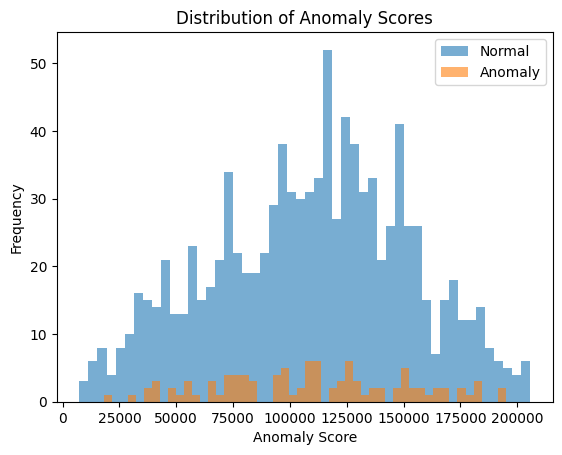

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_true and anomaly_scores are NumPy arrays
# where y_true==0 for normal and y_true==1 for anomalies.


normal_scores = anomaly_scores[y_true == 0]
anomaly_scores_only = anomaly_scores[y_true == 1]

plt.hist(normal_scores, bins=50, alpha=0.6, label='Normal')
plt.hist(anomaly_scores_only, bins=50, alpha=0.6, label='Anomaly')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.legend()
plt.show()